Names: Trevor Doucet and Andrew Selius

GitHub Project Website: https://trevordoucet.github.io/baseball/ 

Project Description: Our project aims to look at MLB pitching data in order to find relationships between the various factors of a pitch and their results. Factors such as pitch type, release velocity, and spin rate are a few of the many factors that go into a single pitch, and we aim to see if there are any relationships between these factors and their success rate in yielding strikes against a hitter. Some preliminary questions we have come up with are as follows:

- Is there a relationship between spin-rate and the number of resulting strikes/strikeouts?
- What factors correlate strongest with a strike being called from a given pitch?
- What players exhibit the most successful pitch characteristics as a result of the trends found in the first two questions?

We intend to gather our data from https://baseballsavant.mlb.com/ . This website provides official and comprehensive data from all MLB games, and the dataset used below is a reflection of that vastness. The main challenges we faced involved filtering out features that we found to be depricated or unnecessary (for now, at least).

Since two people are involved in this project, our collaboration plan is as follows:
- Weekly meetings/working sessions over Google Meets, more as needed.
- Communication over text/Whatsapp for updates, meeting coordination, etc. This will be as needed, but from having worked together in the past we expect to communicate multiple times per week in addition to the working sessions.
- GitHub repository (already created) to coordinate code and keep track of versioning.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Savant Raw Data
The data we will be importing is general pitch data from the top 25 pitchers (ranked by number of pitches thrown) between the dates of 09/19/2023 and 10/01/2023. This will serve as a starting point for our analysis as we look to expand our date range for this analysis.

In [2]:
df = pd.read_csv('../Raw Data/savant_data.csv')

### Desired Columns
In the below cell, we are filtering our data to the features we have deemed appropriate (for now). We are looking to see how these factors affect the result of the pitch (noted in the 'events' column).

In [10]:
df.dropna()
df = df[['player_name', 'pitch_type', 'pitch_name', 'release_speed',
           'game_date', 'release_spin_rate', 'description',
           'events', 'hit_distance_sc', 'pitch_number', 'strikes', 'balls']]

 ### Amount of Pitches by Pitch Type

In [11]:
pitches_amount = df.groupby('pitch_name').size().to_frame('Total Pitches').reset_index()

In [12]:
more_popular = pitches_amount[pitches_amount['Total Pitches'] >= 1000]
less_popular = pitches_amount[pitches_amount['Total Pitches'] < 1000]

### Bar Plot of Pitch Amounts by Pitch Type
Below are bar charts depicting the frequency of pitches of a certain type. In order to better represent the data, we split the dataset into "more popular" and "less popular" pitch types.

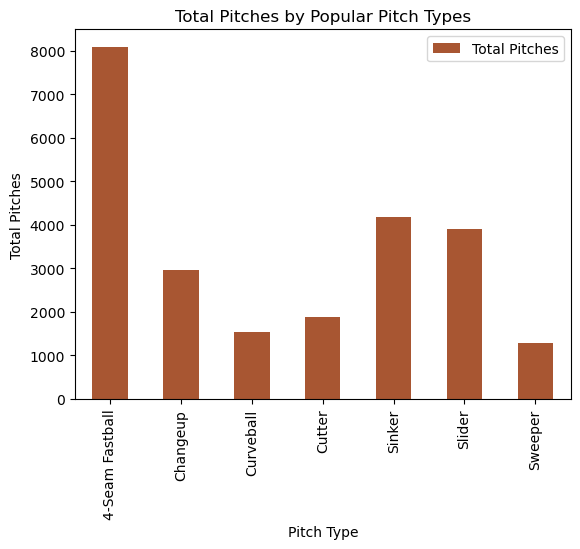

In [13]:
more_popular.plot.bar(x ='pitch_name', y ='Total Pitches', color='#a85632')

plt.xlabel('Pitch Type')
plt.ylabel('Total Pitches')
plt.title('Total Pitches by Popular Pitch Types')
plt.show()

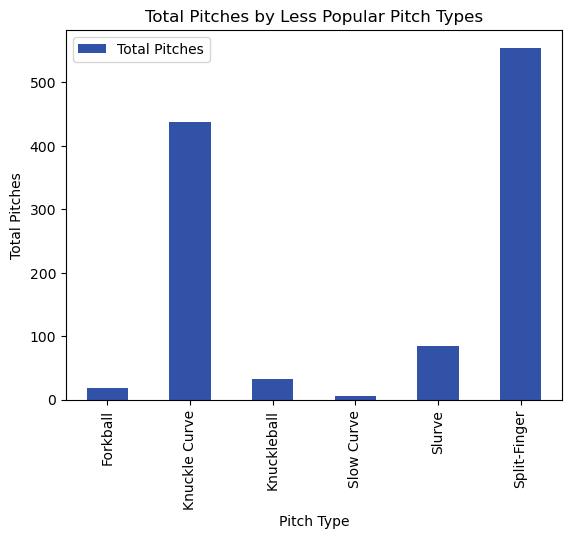

In [14]:
less_popular.plot.bar(x ='pitch_name', y ='Total Pitches', color='#3252a8')

plt.xlabel('Pitch Type')
plt.ylabel('Total Pitches')
plt.title('Total Pitches by Less Popular Pitch Types')
plt.show()

### Interesting Stat

In [15]:
spin_rate = df[df['pitch_name'] == 'Knuckleball']['release_spin_rate'].mean()
fast_kb = df[df['pitch_name'] == 'Knuckleball']['release_speed'].max()

print(f'Average Knuckleball spin rate is {spin_rate} rpm')
print(f'Fastest Knuckleball recorded was {fast_kb} mph')

Average Knuckleball spin rate is 218.25 rpm
Fastest Knuckleball recorded was 80.9 mph


In [16]:
round(df[df['pitch_name'] == '4-Seam Fastball']['release_spin_rate'].mean(), 2)

2268.28